# Recommender

This version is based on a kaggle version 

## Import

In [4]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
#import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
# sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.

from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
              
import numpy as np  

import os                   
from random import shuffle  
from zipfile import ZipFile



#TL pecific modules
from keras.applications.vgg16 import VGG16

## Exploratory 

In [5]:
column_list = ['userId', 'movieId', 'rating', 'timestamp']
data_content =  pd.read_csv('ml-100k/u.data', delimiter='\t', names=column_list) 


In [6]:
df = data_content.copy()
df.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
len(df['userId'].unique())

943

In [8]:
len(df['movieId'].unique())

1682

We have 943 different users and 1682 different movies. We have 100000 ratings. We have 6.3% ratings. What are the minimum and maximum ratings. 

In [9]:
print(df['rating'].min())
print(df['rating'].max())

1
5


In [10]:
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

# I don't know if it is useful after

In [11]:
df.userId

0        195
1        185
2         21
3        243
4        165
        ... 
99995    879
99996    715
99997    275
99998     12
99999     11
Name: userId, Length: 100000, dtype: int16

In [12]:
df['userId'].value_counts(ascending=True)

925     20
684     20
165     20
739     20
35      20
      ... 
275    518
449    540
12     636
654    685
404    737
Name: userId, Length: 943, dtype: int64

## Utility matrix

The utility matrix is the matrix where the user are the rows and the movies are the columns. The ratings are the matrix elements. 

In [13]:
index = list(df['userId'].unique())
columns = list(df['movieId'].unique())
index = sorted(index)
columns = sorted(index)

util_df = pd.pivot_table(data=df, values='rating', index ='userId', columns='movieId')
util_df

movieId,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
userId,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The objective is to fill the Nan Value with estimated ratings. First all the NaN are transformed in zeros. 

In [14]:
util_df.fillna(0)

movieId,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
userId,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training and Validation sets

In [15]:
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

# apply the lambda function on each user

In [16]:
split = np.random.rand(len(df))<0.8
train = df[split]
valid = df[~split]
print(train.shape,valid.shape)
# We take 80% for training 

(79940, 4) (20060, 4)


In [17]:
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())
n_latent_factors=64  # hyperparamter to deal with. 

In [18]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_input

<tf.Tensor 'user_input:0' shape=(?, 1) dtype=int64>

In [19]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)

In [20]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)

In [21]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)

In [22]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)

Creates a model that we then try to fit on data. 

In [23]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')

In [24]:
train.shape
batch_size=128
epochs=50

In [25]:
History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)



Train on 79940 samples, validate on 20060 samples
Epoch 1/50
79940/79940 [==============================] - 2s 20us/step - loss: 13.7379 - val_loss: 13.6820
Epoch 2/50
79940/79940 [==============================] - 1s 16us/step - loss: 13.7267 - val_loss: 13.6717
Epoch 3/50
79940/79940 [==============================] - 1s 16us/step - loss: 13.6900 - val_loss: 13.6107
Epoch 4/50
79940/79940 [==============================] - 1s 18us/step - loss: 13.5398 - val_loss: 13.3514
Epoch 5/50
79940/79940 [==============================] - 1s 17us/step - loss: 13.0607 - val_loss: 12.6330
Epoch 6/50
79940/79940 [==============================] - 1s 14us/step - loss: 12.0230 - val_loss: 11.3092
Epoch 7/50
79940/79940 [==============================] - 1s 14us/step - loss: 10.4220 - val_loss: 9.5183
Epoch 8/50
79940/79940 [==============================] - 1s 14us/step - loss: 8.5044 - val_loss: 7.5775
Epoch 9/50
79940/79940 [==============================] - 1s 15us/step - loss: 6.6002 - val_los

## Model Performance

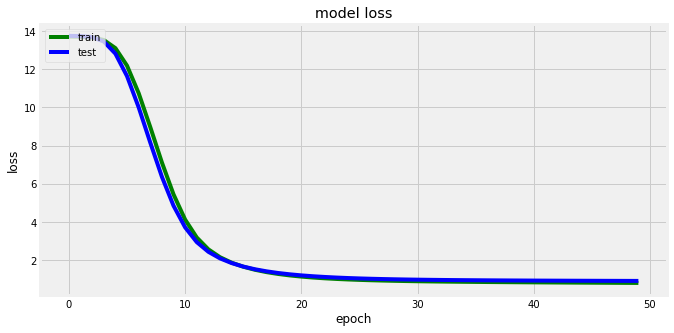

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Neural Network

In [25]:
n_latent_factors=50
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())

In [26]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [28]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

### Model Architecture

In [29]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
nn_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        47150       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        84100       movie_input[0][0]                
__________________________________________________________________________________________________
FlattenUse

In [30]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

In [31]:
batch_size=128
epochs=20

In [32]:
History = nn_model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Train on 80044 samples, validate on 19956 samples
Epoch 1/20
80044/80044 [==============================] - 4s 54us/step - loss: 3.0275 - val_loss: 1.2605
Epoch 2/20
80044/80044 [==============================] - 3s 40us/step - loss: 1.3392 - val_loss: 1.1010
Epoch 3/20
80044/80044 [==============================] - 3s 35us/step - loss: 1.1021 - val_loss: 0.9949
Epoch 4/20
80044/80044 [==============================] - 3s 36us/step - loss: 0.9811 - val_loss: 0.9500
Epoch 5/20
80044/80044 [==============================] - 3s 33us/step - loss: 0.9201 - val_loss: 0.9314
Epoch 6/20
80044/80044 [==============================] - 3s 32us/step - loss: 0.8689 - val_loss: 0.9218
Epoch 7/20
80044/80044 [==============================] - 3s 34us/step - loss: 0.8428 - val_loss: 0.9129
Epoch 8/20
80044/80044 [==============================] - 3s 36us/step - loss: 0.8109 - val_loss: 0.9074
Epoch 9/20
80044/80044 [==============================] - 3s 36us/step - loss: 0.7911 - val_loss: 0.9026
Epoch

## Test And useful Functions

In [32]:
model.predict([np.array([163]), np.array([163])])

array([[2.5606148]], dtype=float32)

In [26]:
column_list = ['movie id', 'movie title', 'release date', 'video release date','IMDb URL','unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War',' Western']
item_content =  pd.read_csv('ml-100k/u.item', delimiter='\|', names=column_list, index_col=column_list[0], engine="python")

def get_movie_name(movie_id, item_content):
        """
        Get the name of a movie from it's id.
        Args:
            movie_id = the id for the movie
        
        Returns:
            The movie title for the specified movie_id.
        """

        movies = item_content.loc[movie_id, 'movie title']
        return movies
    
def predict_for_user(user_id, movie_id,model):    
    """
    Predict if a user will like a specific movie.
    Args:
        user_id = The user's user_id.
        movie_id = The movie's movie_id.
    Returns:
        A prediction of how the user would rate the movie.
    """

    prediction = model.predict([np.array([user_id]), np.array([movie_id])])
    prediction = round(prediction[0][0])

    # astype(int) converts the numpy float32 value to an integer
    return prediction.astype(int)

In [27]:
predict_for_user(163,163,model)

3

In [29]:
get_movie_name(163,item_content)

'Return of the Pink Panther, The (1974)'